In [1]:
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training

from helper.dataloaders import get_sinusoid_example
from helper.util import plot_regression

n_epochs = 1000
torch.manual_seed(711)
# sample toy data example
X_train, y_train, train_loader, X_test = get_sinusoid_example(sigma_noise=0.3)

### Training a MAP

We now use `pytorch` to train a neural network with single hidden layer and Tanh activation.
The trained neural network will be our MAP estimate.
This is standard so nothing new here, yet:

In [2]:
# create and train MAP model
def get_model():
    torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )
model = get_model()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

### Fitting and optimizing the Laplace approximation using empirical Bayes

With the MAP-trained model at hand, we can estimate the prior precision and observation noise
using empirical Bayes after training.
The `Laplace` method is called to construct a LA for `"regression"` with `"all"` weights.
As default `Laplace` returns a Kronecker factored LA, we use `"full"` instead on this small example.
We fit the LA to the training data and initialize `log_prior` and `log_sigma`.
Using Adam, we minimize the negative log marginal likelihood for `n_epochs`.

In [3]:
la = Laplace(model, "regression", subset_of_weights="all", hessian_structure="full")
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

The obtained observation noise is close to the ground truth with a value of \\(\\sigma \\approx 0.28\\)
without the need for any validation data.
The resulting prior precision is \\(\\delta \\approx 0.10\\).

### Bayesian predictive

Here, we compare the MAP prediction to the obtained LA prediction.
For LA, we have a closed-form predictive distribution on the output \\(f\\) which is a Gaussian
\\(\\mathcal{N}(f(x;\\theta\_{MAP}), \\mathbb{V}[f] + \\sigma^2)\\):

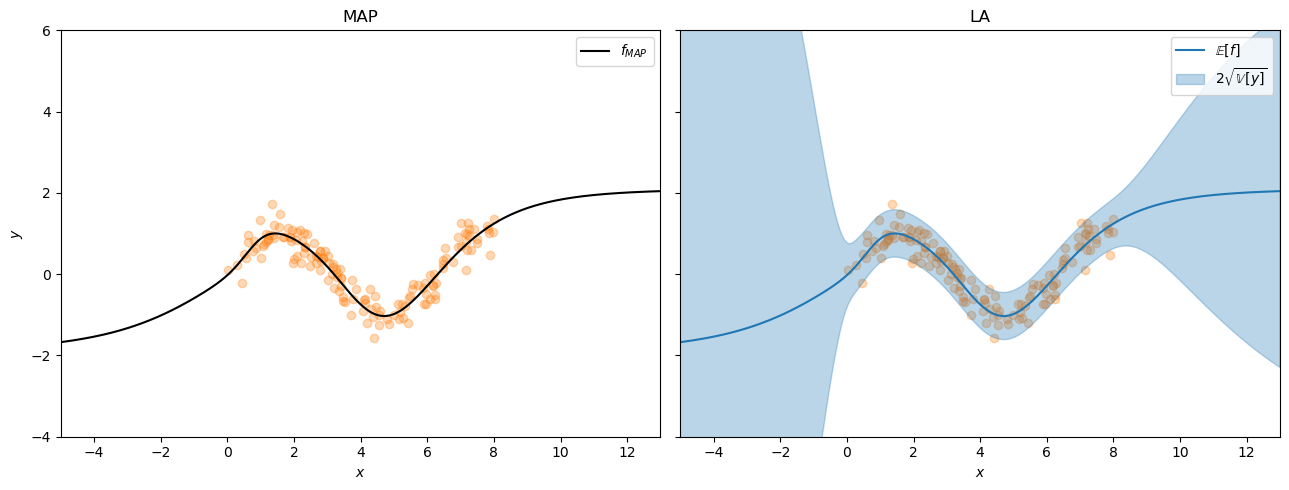

FileNotFoundError: [Errno 2] No such file or directory: 'docs/regression_example.png'

<Figure size 640x480 with 0 Axes>

In [4]:
x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

figsize = (13,5)
plot_regression(X_train, y_train, x, f_mu, pred_std, figsize=figsize)

In comparison to the MAP, the predictive shows useful uncertainties.
When our MAP is over or underfit, the Laplace approximation cannot fix this anymore.
In this case, joint optimization of MAP and marginal likelihood can be useful.

### Jointly optimize MAP and hyperparameters using online empirical Bayes

We provide a utility method `marglik_training` that implements the algorithm proposed in [1].
The method optimizes the neural network and the hyperparameters in an interleaved way
and returns an optimally regularized LA.
Below, we use this method and plot the corresponding predictive uncertainties again:

In [ ]:
model = get_model()
la, model, margliks, losses = marglik_training(
    model=model, train_loader=train_loader, likelihood="regression",
    hessian_structure="full", backend=BackPackGGN, n_epochs=n_epochs,
    optimizer_kwargs={"lr": 1e-2}, prior_structure="scalar"
)

f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression(X_train, y_train, x, f_mu, pred_std, figsize=figsize)

# Full Code example

In [5]:
import numpy as np
import torch
from helper.dataloaders import get_sinusoid_example
from helper.util import plot_regression

from laplace import Laplace, marglik_training
from laplace.curvature.backpack import BackPackGGN

In [6]:
n_epochs = 1000
torch.manual_seed(711)

# create toy regression data
X_train, y_train, train_loader, X_test = get_sinusoid_example(sigma_noise=0.3)

# construct single layer neural network
def get_model():
    torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Linear(1, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )

model = get_model()

In [7]:
# train MAP
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

In [8]:
la = Laplace(model, "regression", subset_of_weights="all", hessian_structure="full")
la.fit(train_loader)
log_prior, log_sigma = (
    torch.ones(1, requires_grad=True),
    torch.ones(1, requires_grad=True),
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_epochs):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

In [9]:
# Serialization for fitted quantities
state_dict = la.state_dict()
torch.save(state_dict, "state_dict.bin")

la = Laplace(model, "regression", subset_of_weights="all", hessian_structure="full")
# Load serialized, fitted quantities
la.load_state_dict(torch.load("state_dict.bin"))

print(
    f"sigma={la.sigma_noise.item():.2f}",
    f"prior precision={la.prior_precision.item():.2f}",
)

sigma=0.28 prior precision=0.10


C:\Users\Mischa\AppData\Local\Temp\ipykernel_10364\396025782.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  la.load_state_dict(torch.load("state_dict.bin"))


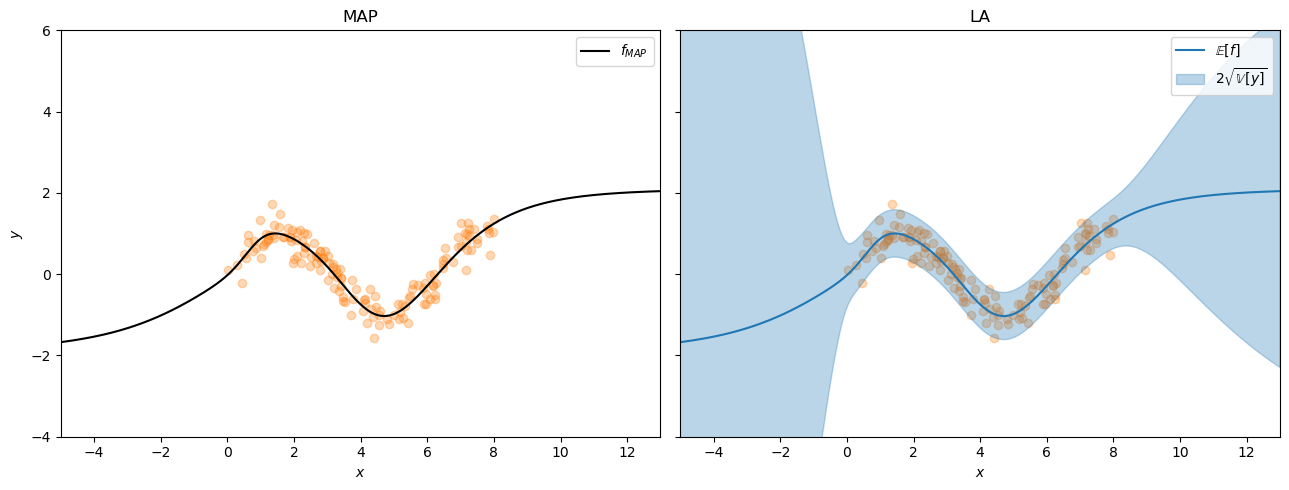

FileNotFoundError: [Errno 2] No such file or directory: 'docs/regression_example.png'

<Figure size 640x480 with 0 Axes>

In [10]:
x = X_test.flatten().cpu().numpy()

# Two options:
# 1.) Marginal predictive distribution N(f_map(x_i), var(x_i))
# The mean is (m,k), the var is (m,k,k)
f_mu, f_var = la(X_test)

# 2.) Joint pred. dist. N((f_map(x_1),...,f_map(x_m)), Cov(f(x_1),...,f(x_m)))
# The mean is (m*k,) where k is the output dim. The cov is (m*k,m*k)
f_mu_joint, f_cov = la(X_test, joint=True)

# Both should be true
assert torch.allclose(f_mu.flatten(), f_mu_joint)
assert torch.allclose(f_var.flatten(), f_cov.diag())

f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().detach().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item() ** 2)

figsize = (13,5)

plot_regression(
    X_train, y_train, x, f_mu, pred_std, file_name="regression_example", plot=True, save=True, figsize=figsize
)

In [ ]:
# alternatively, optimize parameters and hyperparameters of the prior jointly
model = get_model()
la, model, margliks, losses = marglik_training(
    model=model,
    train_loader=train_loader,
    likelihood="regression",
    hessian_structure="full",
    backend=BackPackGGN,
    n_epochs=n_epochs,
    optimizer_kwargs={"lr": 1e-2},
    prior_structure="scalar",
)

print(
    f"sigma={la.sigma_noise.item():.2f}",
    f"prior precision={la.prior_precision.numpy()}",
)

In [ ]:
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item() ** 2)
plot_regression(
    X_train,
    y_train,
    x,
    f_mu,
    pred_std,
    file_name="regression_example_online",
    plot=True,
    save=True,
    figsize=figsize,
)